## Task instructions

### Introduction

In this task, you will take the first critical steps toward building a predictive model for customer churn. Your work will involve gathering relevant data, conducting EDA, and preparing the data set for model development. These activities are foundational for ensuring the accuracy and reliability of your subsequent analysis and predictions.

### Instructions

#### Identify and gather data:

    - Review the provided data sources and select those most relevant for predicting customer churn.
    - Focus on key areas such as customer demographics, transaction history, and customer service interactions.
    - Document your selection criteria and rationale for choosing each data set, ensuring that the data will provide meaningful insights into customer behaviour.

#### Perform EDA:

    - Use statistical techniques and data visualisation tools to explore the data sets.
    - Create visualisations such as histograms, scatter plots, and box plots to understand distributions, trends, and relationships between variables.
    - Identify key features that may influence customer churn, paying special attention to patterns or anomalies that could be significant.

#### Clean and preprocess the data:

    - Handle missing values by choosing appropriate methods such as imputation, removal, or flagging. Justify your chosen method based on the data and context.
    - Detect and address outliers that could skew the analysis or predictions. Decide whether to cap, transform, or remove outliers based on their nature and potential impact.
    - Standardise or normalise numerical features to ensure consistent scales across variables. This step is crucial for preparing the data for machine learning algorithms.
    - Encode categorical variables using techniques like one-hot encoding to transform them into a numerical form appropriate for analysis.

#### Deliverable:

    - File submission: Submit a comprehensive report detailing your data gathering, EDA, and data cleaning processes. The report should include:
        - A summary of the data sets selected and the rationale for their inclusion
        Visualisations and statistical summaries from the EDA
        - A description of the data cleaning and preprocessing steps taken
        The cleaned and preprocessed data set ready for model building

Ensure that your report is clear, concise, and well-organised, as it will be a key component of the project's success, guiding future analysis and model development.

In [23]:
!pip install imbalanced-learn
!pip install xgboost

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import joblib


In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
# Load the Excel file
excel_path = "/content/drive/MyDrive/WorldQuant/DataScience/Customer_Churn_Data_Large.xlsx"

# Read all sheets
all_sheets = pd.read_excel(excel_path, sheet_name=None, index_col=0)

# Concatenate sheets by columns after resetting the index of each DataFrame
merged_df = pd.concat([df.reset_index(drop=True) for df in all_sheets.values()], axis=1)

# Save as a single CSV
merged_df.to_csv("/content/drive/MyDrive/WorldQuant/DataScience/merged_customer_churn_data.csv", index=False, encoding='utf-8')


In [27]:
# Load the merged CSV file
data= pd.read_csv("/content/drive/MyDrive/WorldQuant/DataScience/merged_customer_churn_data.csv")

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   float64
 1   Gender            1000 non-null   object 
 2   MaritalStatus     1000 non-null   object 
 3   IncomeLevel       1000 non-null   object 
 4   TransactionID     5054 non-null   int64  
 5   TransactionDate   5054 non-null   object 
 6   AmountSpent       5054 non-null   float64
 7   ProductCategory   5054 non-null   object 
 8   InteractionID     1002 non-null   float64
 9   InteractionDate   1002 non-null   object 
 10  InteractionType   1002 non-null   object 
 11  ResolutionStatus  1002 non-null   object 
 12  LastLoginDate     1000 non-null   object 
 13  LoginFrequency    1000 non-null   float64
 14  ServiceUsage      1000 non-null   object 
 15  ChurnStatus       1000 non-null   float64
dtypes: float64(5), int64(1), object(10)
memory

# select the most relevant features for predicting customer churn.

Focus on key areas such as customer demographics, transaction history, and customer service interactions.

In [29]:
relevant_columns = ["Age","Gender","MaritalStatus","IncomeLevel","TransactionDate","AmountSpent","ProductCategory","InteractionDate","InteractionType","ResolutionStatus","LastLoginDate","LoginFrequency","ServiceUsage","ChurnStatus"]
# Filter the DataFrame to include only relevant columns
filtered_data = data[relevant_columns]

## Summary of Selected Features for Customer Churn Prediction

| **Data Area**            | **Selected Columns**                                              | **Rationale**                                                                 |
|--------------------------|-------------------------------------------------------------------|-------------------------------------------------------------------------------|
| **Demographics**         | `Age`, `Gender`, `MaritalStatus`, `IncomeLevel`                  | Profile and segment customers based on stable attributes                     |
| **Transaction History**  | `TransactionDate`, `AmountSpent`, `ProductCategory`              | Identify spending patterns, recency, and frequency of purchases              |
| **Customer Interactions**| `InteractionDate`, `InteractionType`, `ResolutionStatus`         | Measure satisfaction and service quality through complaint resolution trends |
| **Engagement / Usage**   | `LastLoginDate`, `LoginFrequency`, `ServiceUsage`                | Detect disengagement and usage drop as early churn indicators                |
| **Not Directly Used**    | `CustomerID`, `TransactionID`, `InteractionID`    | Used for identification, aggregation              |


## EDA

In [30]:
# Basic info and summary stats
print(filtered_data.info())
print(filtered_data.describe(include='all').T)
print(filtered_data['ChurnStatus'].value_counts())  # Target variable distribution


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054 entries, 0 to 5053
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               1000 non-null   float64
 1   Gender            1000 non-null   object 
 2   MaritalStatus     1000 non-null   object 
 3   IncomeLevel       1000 non-null   object 
 4   TransactionDate   5054 non-null   object 
 5   AmountSpent       5054 non-null   float64
 6   ProductCategory   5054 non-null   object 
 7   InteractionDate   1002 non-null   object 
 8   InteractionType   1002 non-null   object 
 9   ResolutionStatus  1002 non-null   object 
 10  LastLoginDate     1000 non-null   object 
 11  LoginFrequency    1000 non-null   float64
 12  ServiceUsage      1000 non-null   object 
 13  ChurnStatus       1000 non-null   float64
dtypes: float64(4), object(10)
memory usage: 552.9+ KB
None
                   count unique             top  freq        mean         std  \


In [31]:
filtered_data.isnull().sum()


,0
Age,4054
Gender,4054
MaritalStatus,4054
IncomeLevel,4054
TransactionDate,0
AmountSpent,0
ProductCategory,0
InteractionDate,4052
InteractionType,4052
ResolutionStatus,4052


## Key Features Influencing Customer Churn

| **Feature**           | **Observed Patterns / Anomalies**                                                                                                          | **Potential Influence on Churn**                                                                                     |
|-----------------------|--------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------|
| `Age`                 | Churn rates tend to be higher among younger customers and older age groups, possibly due to lifestyle or tech affinity differences.         | Targeted retention strategies might be needed for these groups.                                                      |
| `LoginFrequency`      | Users with low login frequency are more likely to churn. Some anomalies show users with **zero** logins yet marked as not churned.         | Strong indicator of disengagement. Anomalies might be due to backend logins or data entry errors.                    |
| `AmountSpent`         | High-spending customers generally have lower churn. However, a few high spenders still churned, possibly due to service issues.             | Spending behavior reflects customer value and satisfaction; sudden drop may predict churn.                           |
| `ServiceUsage`        | Certain services (e.g., basic tier) have disproportionately higher churn rates. Premium services show better retention.                     | Indicates that churn might be service-specific; some services may not meet customer expectations.                    |
| `ResolutionStatus`    | A high number of unresolved issues or 'Pending' cases correlate with churners. Some churners had multiple unresolved interactions.         | Poor customer support experience drives churn. Delayed or unsatisfactory resolutions are red flags.                  |
| `LastLoginDate`       | Many churners had no login for over 30 days before they churned. Recency is a clear predictor.                                              | Strong behavioral churn signal—lack of platform interaction is a warning sign.                                       |
| `InteractionType`     | Churners tend to contact support more via chat or email, possibly due to unresolved frustrations.                                           | Type of interaction might hint at urgency or dissatisfaction.                                                        |
| `IncomeLevel`         | Lower-income segments exhibit higher churn, possibly due to cost sensitivity. However, some high-income users also churned unexpectedly.    | Financial capacity may affect retention, especially if services are perceived as expensive or not valuable enough.   |
| `ProductCategory`     | Certain product categories have higher churn rates—e.g., low-cost, fast-moving products.                                                    | Product engagement or satisfaction may vary by category; useful for tailored offerings.                             |

---



### Visualizing Distributions (Histograms)

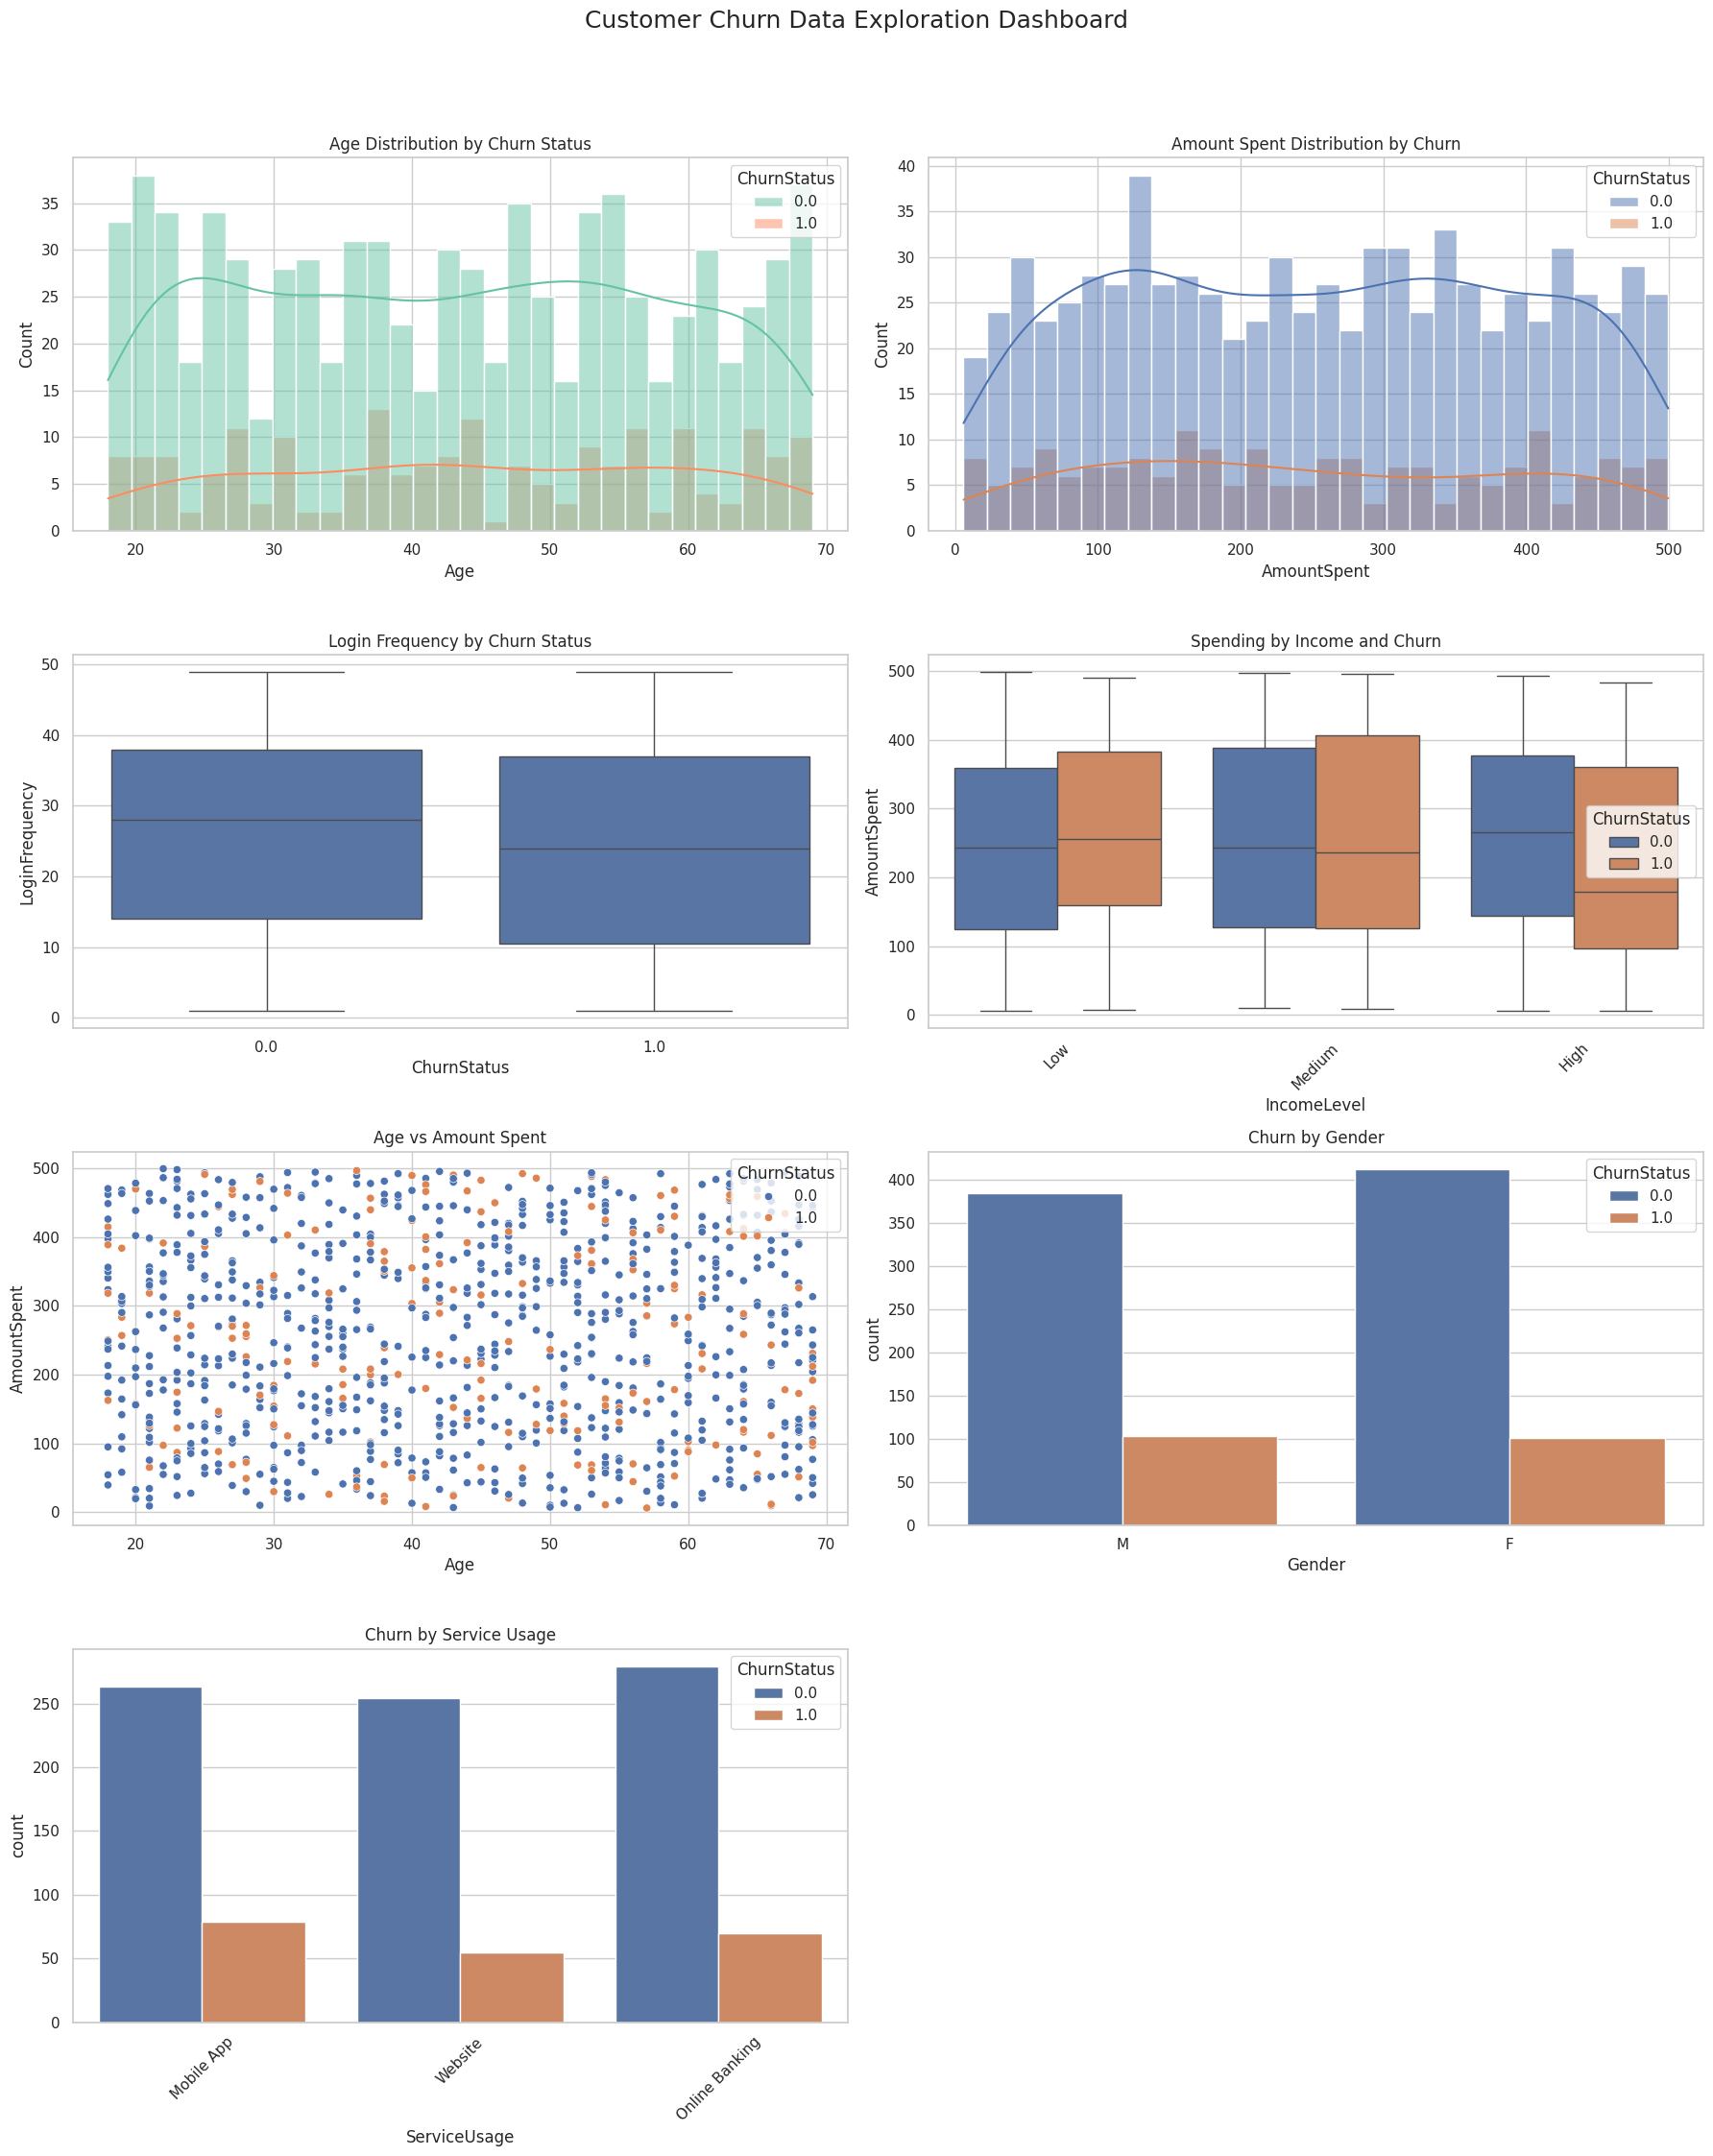

In [32]:

# Set style
sns.set(style="whitegrid")

# Create a figure with subplots (4 rows x 2 columns)
fig, axs = plt.subplots(4, 2, figsize=(18, 22))
fig.suptitle('Customer Churn Data Exploration Dashboard', fontsize=18, y=1.02)

# Plot 1: Age distribution by churn
sns.histplot(data=filtered_data, x='Age', hue='ChurnStatus', kde=True, bins=30, ax=axs[0, 0], palette='Set2')
axs[0, 0].set_title("Age Distribution by Churn Status")

# Plot 2: Amount Spent distribution
sns.histplot(data=filtered_data, x='AmountSpent', hue='ChurnStatus', kde=True, bins=30, ax=axs[0, 1])
axs[0, 1].set_title("Amount Spent Distribution by Churn")

# Plot 3: Boxplot - Login Frequency
sns.boxplot(data=filtered_data, x='ChurnStatus', y='LoginFrequency', ax=axs[1, 0])
axs[1, 0].set_title("Login Frequency by Churn Status")

# Plot 4: Boxplot - Amount Spent by Income Level
sns.boxplot(data=filtered_data, x='IncomeLevel', y='AmountSpent', hue='ChurnStatus', ax=axs[1, 1])
axs[1, 1].set_title("Spending by Income and Churn")
axs[1, 1].tick_params(axis='x', rotation=45)

# Plot 5: Scatter - Age vs Amount Spent
sns.scatterplot(data=filtered_data, x='Age', y='AmountSpent', hue='ChurnStatus', ax=axs[2, 0])
axs[2, 0].set_title("Age vs Amount Spent")

# Plot 6: Countplot - Churn by Gender
sns.countplot(data=filtered_data, x='Gender', hue='ChurnStatus', ax=axs[2, 1])
axs[2, 1].set_title("Churn by Gender")

# Plot 7: Countplot - Churn by Service Usage
sns.countplot(data=filtered_data, x='ServiceUsage', hue='ChurnStatus', ax=axs[3, 0])
axs[3, 0].set_title("Churn by Service Usage")
axs[3, 0].tick_params(axis='x', rotation=45)

# Turn off the last subplot (bottom-right) if not used
axs[3, 1].axis('off')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.95)  # Allow room for suptitle
plt.show()


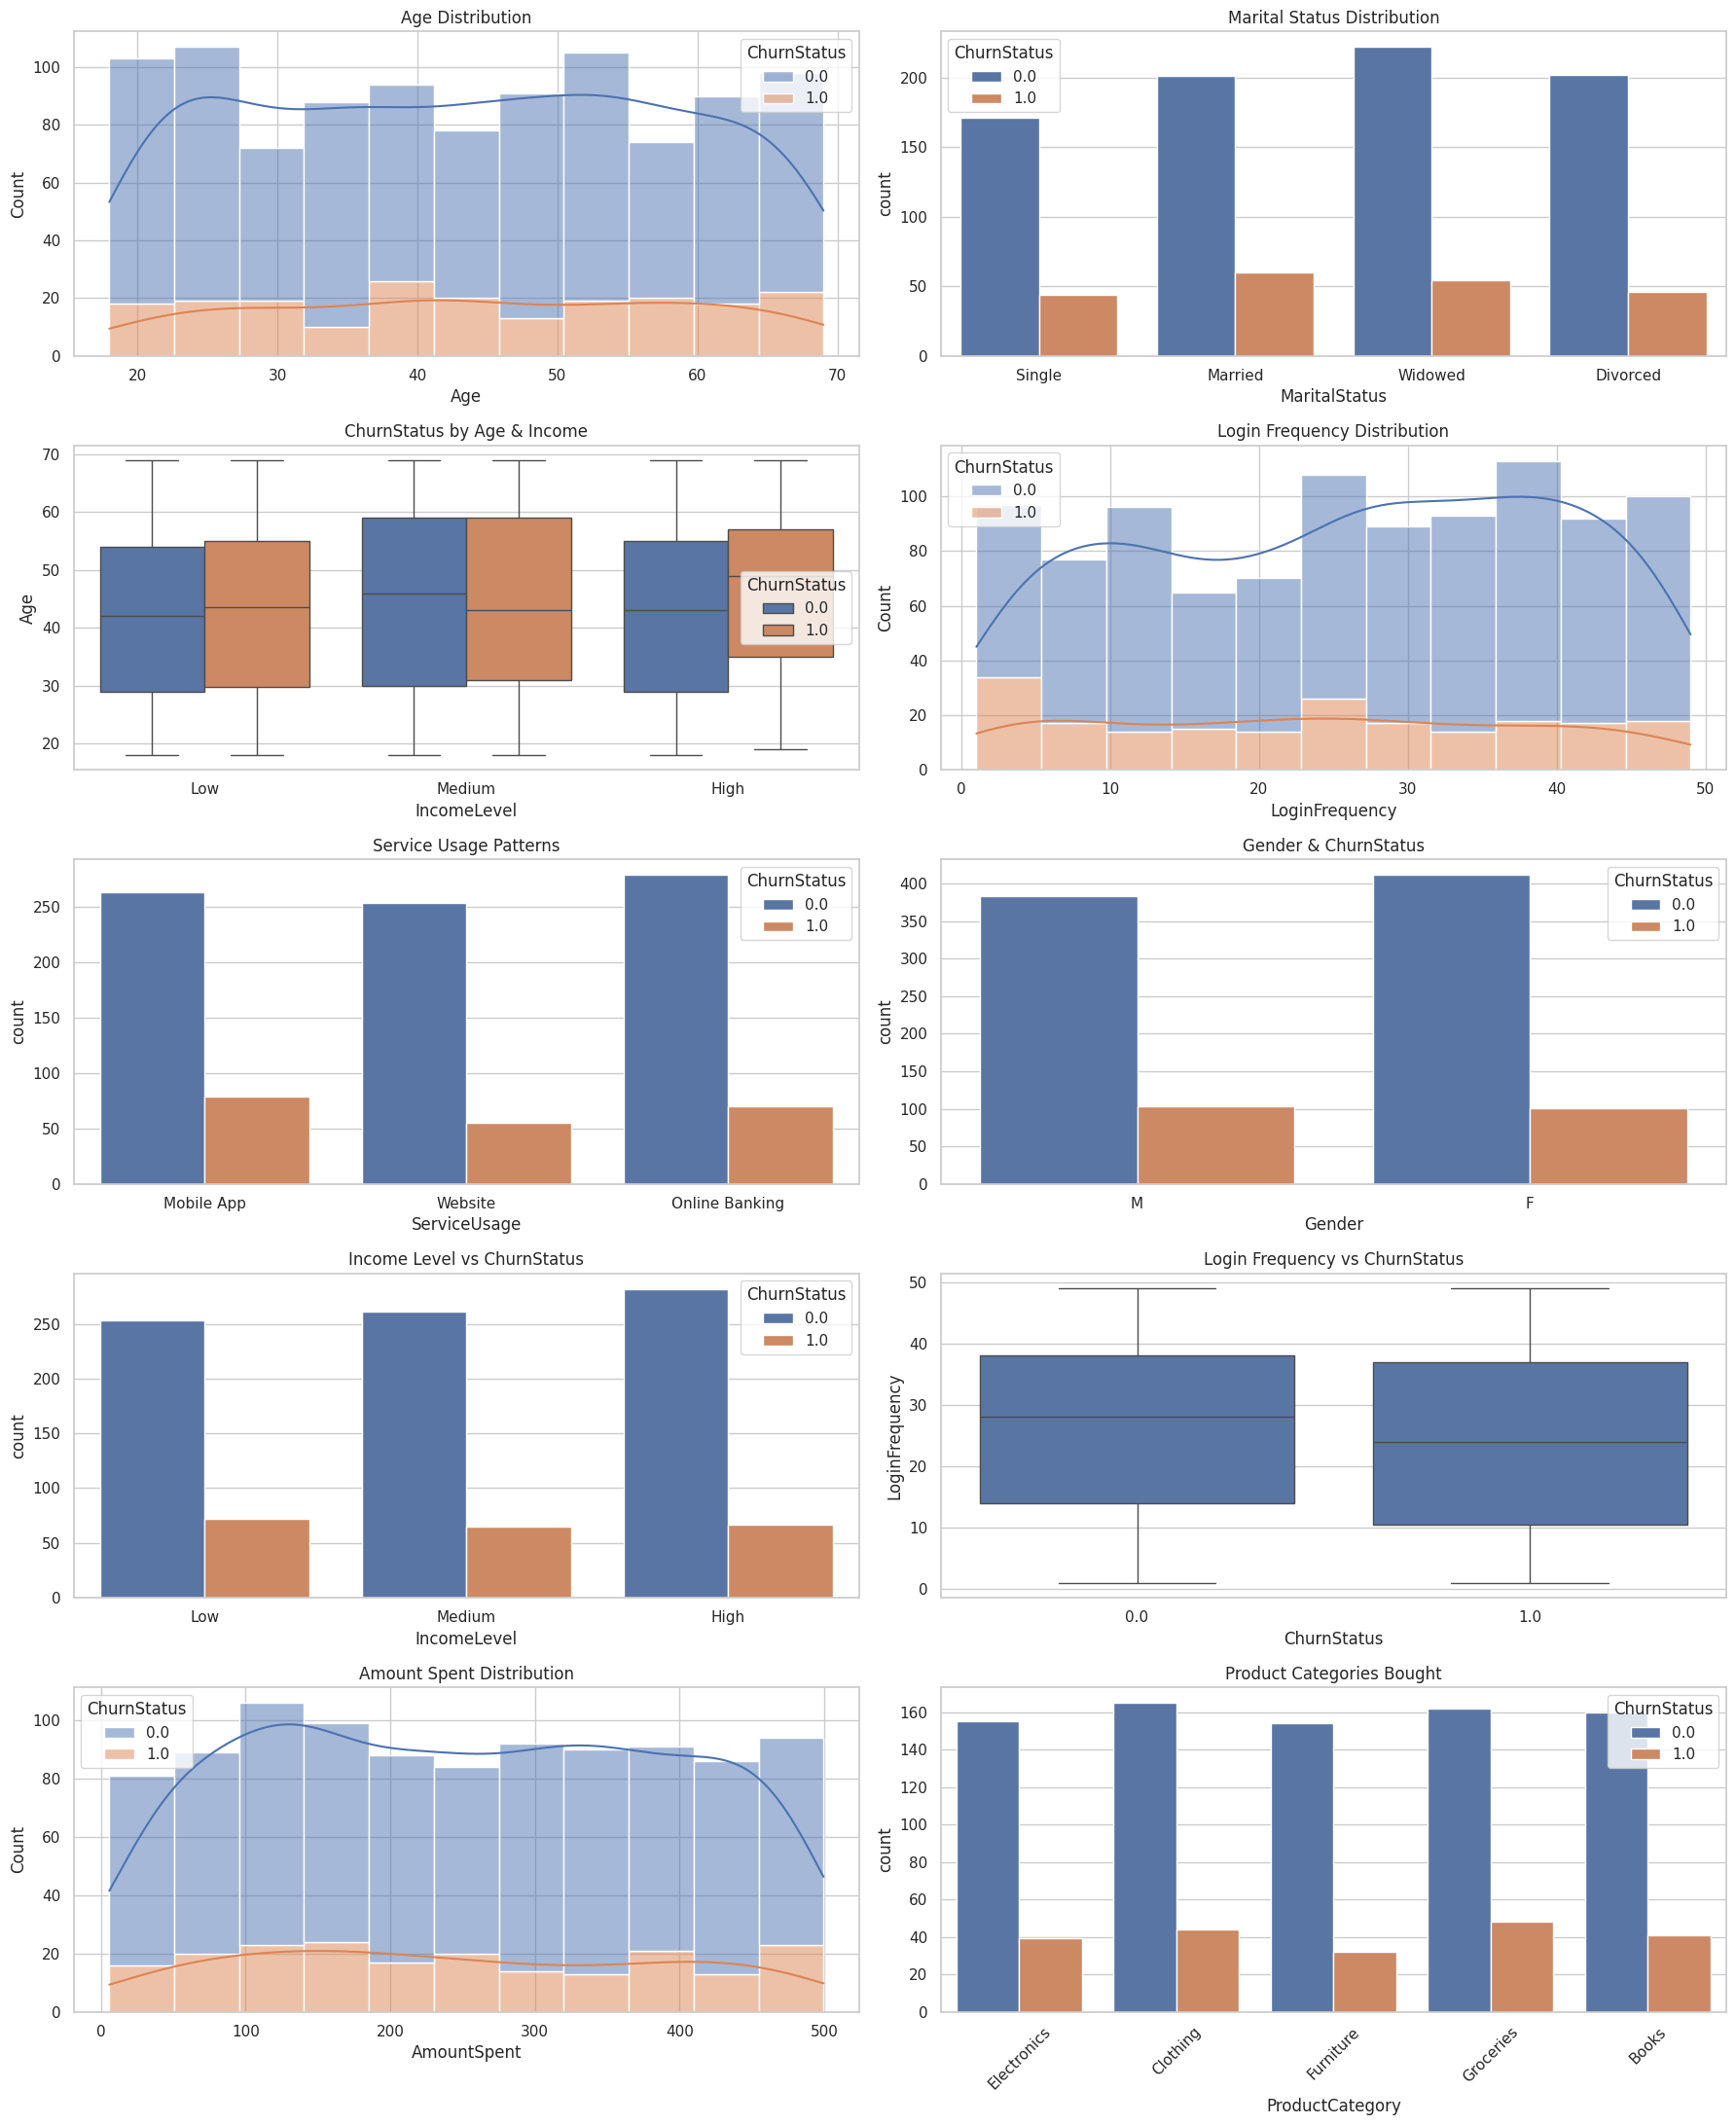

In [33]:

# Set up the matplotlib figure
fig, axs = plt.subplots(5, 2, figsize=(18, 22))
axs = axs.flatten()
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Plot 1: Age Distribution
sns.histplot(data=filtered_data, x="Age", kde=True, ax=axs[0], hue="ChurnStatus", multiple="stack")
axs[0].set_title("Age Distribution")

# Plot 2: Marital Status Distribution
sns.countplot(data=filtered_data, x="MaritalStatus", hue="ChurnStatus", ax=axs[1])
axs[1].set_title("Marital Status Distribution")

# Plot 3: ChurnStatus by Age & Income
sns.boxplot(data=filtered_data, x="IncomeLevel", y="Age", hue="ChurnStatus", ax=axs[2])
axs[2].set_title("ChurnStatus by Age & Income")

# Plot 4: Login Frequency Distribution
sns.histplot(data=filtered_data, x="LoginFrequency", kde=True, hue="ChurnStatus", ax=axs[3], multiple="stack")
axs[3].set_title("Login Frequency Distribution")

# Plot 5: Service Usage Patterns
sns.countplot(data=filtered_data, x="ServiceUsage", hue="ChurnStatus", ax=axs[4])
axs[4].set_title("Service Usage Patterns")

# Plot 6: Gender & ChurnStatus
sns.countplot(data=filtered_data, x="Gender", hue="ChurnStatus", ax=axs[5])
axs[5].set_title("Gender & ChurnStatus")

# Plot 7: Income Level vs ChurnStatus
sns.countplot(data=filtered_data, x="IncomeLevel", hue="ChurnStatus", ax=axs[6])
axs[6].set_title("Income Level vs ChurnStatus")

# Plot 8: Login Frequency vs ChurnStatus
sns.boxplot(data=filtered_data, x="ChurnStatus", y="LoginFrequency", ax=axs[7])
axs[7].set_title("Login Frequency vs ChurnStatus")

# Plot 9: Amount Spent Distribution
sns.histplot(data=filtered_data, x="AmountSpent", kde=True, hue="ChurnStatus", ax=axs[8], multiple="stack")
axs[8].set_title("Amount Spent Distribution")

# Plot 10: Product Categories Bought
sns.countplot(data=filtered_data, x="ProductCategory", hue="ChurnStatus", ax=axs[9])
axs[9].set_title("Product Categories Bought")
axs[9].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### Clean and Preprocess data

In [34]:
# --- 1. Handle Missing Values ---

# Strategy:
# - Drop rows where target (ChurnStatus) is missing
# - Impute numerical columns with median
# - Impute categorical columns with mode

# Drop rows with missing ChurnStatus
filtered_data = filtered_data[filtered_data['ChurnStatus'].notnull()]

# Separate numerical and categorical columns
numerical_cols = ['Age', 'AmountSpent', 'LoginFrequency']
categorical_cols = ['Gender', 'MaritalStatus', 'IncomeLevel', 'ProductCategory',
                    'InteractionType', 'ResolutionStatus', 'ServiceUsage']

# Impute missing values
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

filtered_data[numerical_cols] = num_imputer.fit_transform(filtered_data[numerical_cols])
filtered_data[categorical_cols] = cat_imputer.fit_transform(filtered_data[categorical_cols])


In [35]:
# --- 2. Detect and Address Outliers ---
# Using Z-score method

# Detect outliers using Z-score (absolute value > 3 considered outlier)
z_scores = np.abs(stats.zscore(filtered_data[numerical_cols]))
outliers = (z_scores > 3)

# Cap outliers at 1st and 99th percentiles
for col in numerical_cols:
    lower, upper = filtered_data[col].quantile([0.01, 0.99])
    filtered_data[col] = np.clip(filtered_data[col], lower, upper)

In [36]:
# --- 3. Standardize Numerical Features ---
scaler = StandardScaler()
filtered_data[numerical_cols] = scaler.fit_transform(filtered_data[numerical_cols])


In [37]:
# --- 4. Encode Categorical Variables ---
encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(filtered_data[categorical_cols])
encoded_filtered_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(categorical_cols))

# Combine encoded features with the rest of the data
filtered_data.reset_index(drop=True, inplace=True)
encoded_filtered_data.reset_index(drop=True, inplace=True)
filtered_data_final = pd.concat([filtered_data.drop(columns=categorical_cols), encoded_filtered_data], axis=1)


In [38]:
# Move 'ChurnStatus' column to the last position
columns = [col for col in filtered_data_final.columns if col != 'ChurnStatus'] + ['ChurnStatus']
filtered_data_final = filtered_data_final[columns]

In [39]:
# --- 5. Final Data Preparation ---
# Drop any remaining rows with missing values
filtered_data_final.dropna(inplace=True)
# Reset index
filtered_data_final.reset_index(drop=True, inplace=True)

# Save the cleaned and preprocessed data
filtered_data_final.to_csv("cleaned_customer_churn_data.csv", index=False, encoding='utf-8')
# Display the final shape of the cleaned data
print("Final shape of the cleaned data:", filtered_data_final.shape)
# Show the cleaned and preprocessed data
filtered_data_final.head(20)


Final shape of the cleaned data: (1000, 22)


,Age,TransactionDate,AmountSpent,InteractionDate,LastLoginDate,LoginFrequency,Gender_M,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widowed,...,ProductCategory_Clothing,ProductCategory_Electronics,ProductCategory_Furniture,ProductCategory_Groceries,InteractionType_Feedback,InteractionType_Inquiry,ResolutionStatus_Unresolved,ServiceUsage_Online Banking,ServiceUsage_Website,ChurnStatus
0,1.229628,2022-03-27,1.154712,2022-03-31,2023-10-21,0.575702,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.426547,2022-08-08,-1.397890,2022-03-17,2023-12-05,-1.488513,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
2,-1.658518,2022-07-25,-0.391506,2022-08-24,2023-11-15,-1.630872,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-1.461599,2022-01-25,-1.070642,2022-11-18,2023-08-25,-1.702052,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.461599,2022-07-24,1.019647,2022-07-03,2023-10-27,1.073961,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
5,0.901430,2022-01-09,0.227758,2022-05-05,2023-09-17,-1.702052,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
6,-1.067761,2022-09-16,0.412245,2022-04-29,2023-01-07,0.433343,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
7,-0.411364,2022-11-19,-0.375762,2022-09-13,2023-04-22,-0.634355,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
8,-0.280085,2022-10-08,-0.083957,2022-08-15,2023-06-27,-0.136096,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
9,1.623466,2022-08-15,-1.425354,2022-10-28,2023-01-13,0.219803,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


# Task 2: Building a machine learning model

## Task instructions

### Introduction

In this task, you will focus on developing a robust machine learning model to predict customer churn. Your objective is to select an appropriate algorithm, train and validate the model, and propose evaluation metrics that will help assess its performance. This task is pivotal for providing actionable insights that can inform business strategies at Lloyds Banking Group.

### Instructions

**Select an appropriate machine learning algorithm:**

    - Review the characteristics of the data set and the nature of the churn prediction problem.
    - Consider algorithms such as logistic regression, decision trees, random forests, gradient boosting machines, or neural networks.
    - Choose an algorithm that balances accuracy and interpretability, suitable for the business context.

**Build and train the model:**

    Use the preprocessed data set from Task 1 to train your chosen model.
    Implement techniques like cross-validation to ensure the model generalises well to unseen data.
    Perform hyperparameter tuning to optimise the model’s performance.

**Evaluate model performance:**

    Select appropriate metrics to evaluate the model's performance, such as precision, recall, F1 score, ROC-AUC, and confusion matrix analysis.
    Consider the implications of each metric in the context of imbalanced data sets, ensuring that the evaluation provides a comprehensive view of the model's effectiveness.

**Suggest ways to improve and utilise the model:**

    Provide recommendations on how the model can be used by the business to identify at-risk customers and develop retention strategies.
    Discuss any potential improvements or adjustments to the model that could enhance its accuracy or applicability in different business scenarios.

**Deliverable:**

    Report submission: Compile a comprehensive report that includes:
        - A detailed description of the selected algorithm and the rationale behind its choice.
        - The trained model, along with performance metrics and evaluation results.
        - Suggested ways to utilise the model's predictions for business decision-making and potential areas for improvement.

Ensure that your report is clear, concise, and well-organised, effectively communicating both the technical aspects of the model and its practical applications for the business. This report will be a critical tool for stakeholders to understand and leverage the predictive insights generated by your model.

In [40]:
# Convert date columns to datetime objects
for col in ['TransactionDate', 'InteractionDate', 'LastLoginDate']:
    filtered_data_final[col] = pd.to_datetime(filtered_data_final[col])

# Extract numerical features from date columns (e.g., days since a reference date)
reference_date = filtered_data_final['TransactionDate'].min()  # Or any other relevant reference date
for col in ['TransactionDate', 'InteractionDate', 'LastLoginDate']:
    filtered_data_final[col + '_Days'] = (filtered_data_final[col] - reference_date).dt.days

# Drop the original date columns
filtered_data_final = filtered_data_final.drop(columns=['TransactionDate', 'InteractionDate', 'LastLoginDate'])


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters from GridSearchCV: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Recall: 0.024390243902439025
F1-score: 0.044444444444444446
AUC: 0.5027611596870686
Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       159
         1.0       0.25      0.02      0.04        41

    accuracy                           0.79       200
   macro avg       0.52      0.50      0.46       200
weighted avg       0.68      0.79      0.71       200

Confusion Matrix:
 [[156   3]
 [ 40   1]]
Accuracy Score: 0.785
Feature ranking:
1. Gender_M (0.0775)
2. IncomeLevel_Low (0.0651)
3. ServiceUsage_Online Banking (0.0636)
4. InteractionDate_Days (0.0633)
5. TransactionDate_Days (0.0618)
6. ServiceUsage_Website (0.0614)
7. AmountSpent (0.0574)
8. LoginFrequency (0.0570)
9. Age (0.0537)
10. LastLoginDate_Days (0.0518)
11. MaritalSta

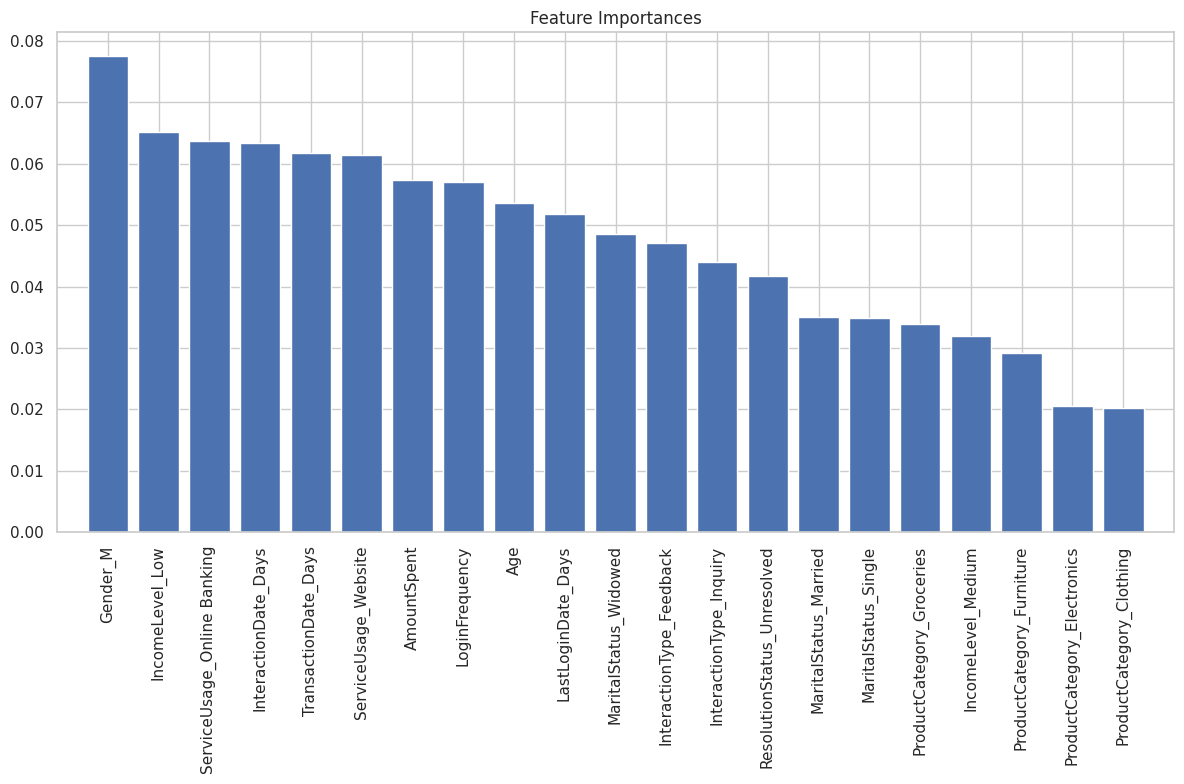

Sample data predictions: [0. 0. 0. 0. 0.]


In [41]:
# Use the preprocessed data set from Task 1 to train your chosen model.
#     Implement techniques like cross-validation to ensure the model generalises well to unseen data.
#     Perform hyperparameter tuning to optimise the model’s performance.

# Split the data into features and target variable
X = filtered_data_final.drop(columns=['ChurnStatus'])
y = filtered_data_final['ChurnStatus']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Initialize the model


smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(random_state=42,class_weight="balanced")
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
# Fit the model
grid_search.fit(X_train, y_train)
# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters from GridSearchCV:", best_params)

# Train the model with the best parameters
best_model = RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train, y_train)
# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred))

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Feature Importance
importances = best_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X.shape[1]):
    print(f"{f + 1}. {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

# Save the trained model
joblib.dump(best_model, '/content/drive/MyDrive/WorldQuant/DataScience/best_random_forest_model.pkl')

# Load the model
loaded_model = joblib.load('/content/drive/MyDrive/WorldQuant/DataScience/best_random_forest_model.pkl')

# Make predictions with the loaded model
sample_data = X_test.sample(5, random_state=42)
sample_predictions = loaded_model.predict(sample_data)
print("Sample data predictions:", sample_predictions)

# Save the predictions to a CSV file
predictions_df = pd.DataFrame(sample_predictions, columns=['ChurnStatus'])
predictions_df.to_csv("/content/drive/MyDrive/WorldQuant/DataScience/sample_predictions.csv", index=False, encoding='utf-8')


In [42]:

# Define models and their parameter grids
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42),  # XGBoost handles class imbalance internally
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],  # Usually smaller depths work well for XGBoost
            'learning_rate': [0.1, 0.01]
        }
    }
}

# Train and evaluate each model
for model_name, model_data in models.items():
    print(f"Training {model_name}...")
    model = model_data['model']
    param_grid = model_data['param_grid']

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                               scoring='accuracy', cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)  # Using data

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Classification Report for {model_name}:\n", classification_report(y_test, y_pred))
    print(f"Confusion Matrix for {model_name}:\n", confusion_matrix(y_test, y_pred))
    print(f"Accuracy Score for {model_name}:", accuracy_score(y_test, y_pred))

Training Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Classification Report for Random Forest:
               precision    recall  f1-score   support

         0.0       0.80      0.98      0.88       159
         1.0       0.25      0.02      0.04        41

    accuracy                           0.79       200
   macro avg       0.52      0.50      0.46       200
weighted avg       0.68      0.79      0.71       200

Confusion Matrix for Random Forest:
 [[156   3]
 [ 40   1]]
Accuracy Score for Random Forest: 0.785
Training XGBoost...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Classification Report for XGBoost:
               precision    recall  f1-score   support

         0.0       0.79      0.96      0.87       159
        